# 沃尔玛终极预测任务
（一般多属性多序列预测问题）

# 适当观察数据集

In [3]:
import pandas as pd
# 读入数据集
sales = pd.read_csv("./data/sales.csv")
calendar = pd.read_csv("./data/calendar.csv")
price = pd.read_csv("./data/price.csv")

In [2]:
sales.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,2,1,0,0,2,1,0


In [3]:
price.head()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


In [4]:
calendar.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011/1/29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011/1/30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011/1/31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011/2/1,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011/2/2,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [2]:
# 观察某个商品的销售额随天数变化的曲线
def see(id, back = True, draw=False, only_last=False):
    if draw:
        import matplotlib.pyplot as plt
        if only_last:
            plt.plot(range(28), sales.iloc[id,-28:])
        else:
            plt.plot(range(1913), sales.iloc[id,6:-28], color='blue')
            plt.plot(range(1913, 1941), sales.iloc[id,-28:], color='red')
        plt.title(f'commodity id : {id}')
        plt.xlabel('day')
        plt.ylabel('sales')
        if only_last == False:
            plt.legend(['past 1913 days','future 28 days'])
    if back:
        if only_last:
            return list(map(int,sales.iloc[id,-28:]))
        else:
            return list(map(int,sales.iloc[id,6:-28]))

### 适当观察销售额变化-》发现序列差异其实很大-》十分具有挑战的任务「30000个样本在1941天的销售额，且包含日期在内有多维特征」

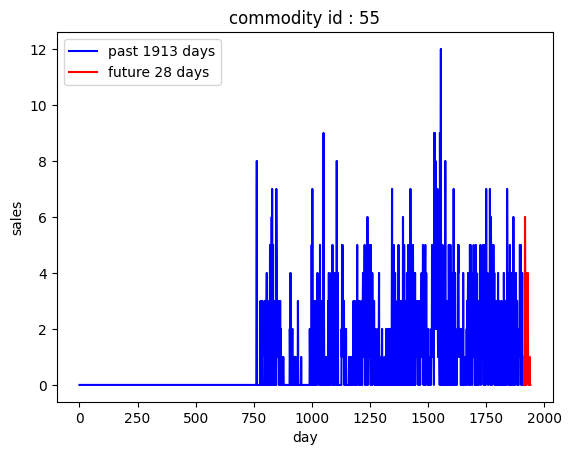

In [6]:
see(55, back=False, draw=True)

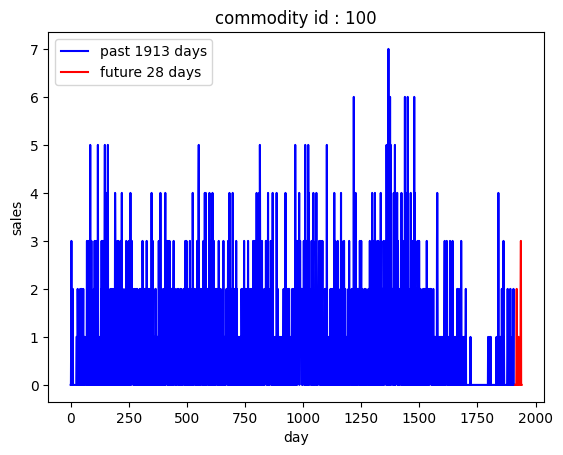

In [7]:
see(100, back=False, draw=True)

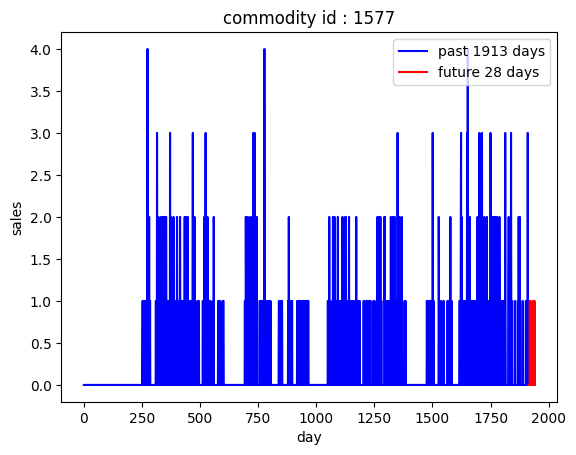

In [102]:
see(1577, back=False, draw=True)

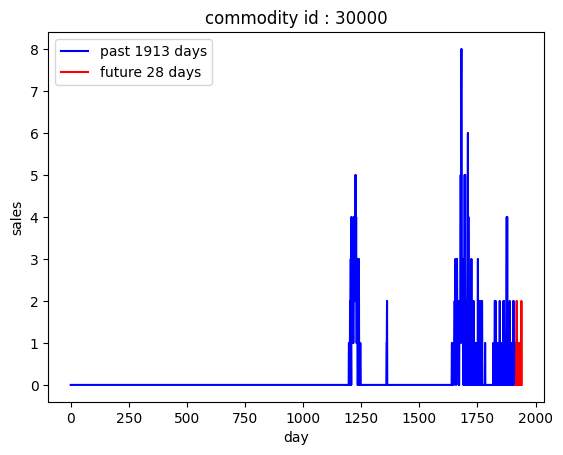

In [8]:
see(30000, back=False, draw=True)

# 从原始数据构建特征序列

### 构建price矩阵（与sales销售额部分形状相同）

In [63]:
# sales = pd.read_csv("./data/sales.csv")
# calendar = pd.read_csv("./data/calendar.csv")
# price = pd.read_csv("./data/price.csv")
# Dailyprice = []
# for i in range(len(sell)):
#     tmp = []
#     for j in range(1941):
#         dpe = price[(price['wm_yr_wk'] == date.iloc[j]['wm_yr_wk']) & 
#                     (price['store_id'] == sell.iloc[i]['store_id']) &
#                     (price['item_id'] == sell.iloc[i]['item_id'])]['sell_price']
#         if len(dpe) == 0:
#             dpe = 0
#         tmp.append(dpe)
#     Dailyprice.append(tmp)
# 上面的做法效率太低，查询需要数日才能完成，改进的price构建方法见下面的cell

### 使用pandas优化过的merge和pivot以及reindex方法实现

In [81]:
import pandas as pd
import numpy as np

# 将price数据集透视为二维表格，并将列数重新索引
df = pd.merge(price, calendar[['wm_yr_wk', 'd']], on='wm_yr_wk')
df = df[df['store_id'].isin(sales['store_id'].unique()) & df['item_id'].isin(sales['item_id'].unique())]
df = df.pivot(index=['store_id', 'item_id'], columns='d', values='sell_price')
df = df.reindex(columns=[f'd_{i}' for i in range(1, 1942)])

# 将二维表格转换为二维NumPy数组
Dailyprice = df.values
Dailyprice[np.isnan(Dailyprice)] = 0

### 存储sell_price（防止存储错误的临时数据，因此注释）

In [84]:
# import pickle
# with open('sell_price.pkl', 'wb') as f:
#     pickle.dump(Dailyprice, f)

### 读取sell_price

In [46]:
import pickle
with open('./data/sell_price.pkl', 'rb') as f:
    sell_price = pickle.load(f)

In [48]:
min_vals = np.min(sell_price, axis=1, keepdims=True)
max_vals = np.max(sell_price, axis=1, keepdims=True)

normalized_price = (sell_price - min_vals) / (max_vals - min_vals)

/Users/bgm/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


In [49]:
normalized_price

array([[0.     , 0.     , 0.     , ..., 1.     , 1.     , 1.     ],
       [0.     , 0.     , 0.     , ..., 1.     , 1.     , 1.     ],
       [0.     , 0.     , 0.     , ..., 1.     , 1.     , 1.     ],
       ...,
       [0.33125, 0.33125, 0.33125, ..., 1.     , 1.     , 1.     ],
       [0.     , 0.     , 0.     , ..., 1.     , 1.     , 1.     ],
       [    nan,     nan,     nan, ...,     nan,     nan,     nan]])

In [50]:
import numpy as np
normalized_price = np.nan_to_num(normalized_price, nan=0)

In [51]:
normalized_price

array([[0.     , 0.     , 0.     , ..., 1.     , 1.     , 1.     ],
       [0.     , 0.     , 0.     , ..., 1.     , 1.     , 1.     ],
       [0.     , 0.     , 0.     , ..., 1.     , 1.     , 1.     ],
       ...,
       [0.33125, 0.33125, 0.33125, ..., 1.     , 1.     , 1.     ],
       [0.     , 0.     , 0.     , ..., 1.     , 1.     , 1.     ],
       [0.     , 0.     , 0.     , ..., 0.     , 0.     , 0.     ]])

In [62]:
import pickle

with open('./data/price_norm.pickle', 'wb') as f:
    pickle.dump(normalized_price, f)

### sell_price成功表示了每一个商品在1941天内的销售价格，如果该天没有销售价格记录，那么默认该商店该天没有销售该商品，销售价格赋值为0

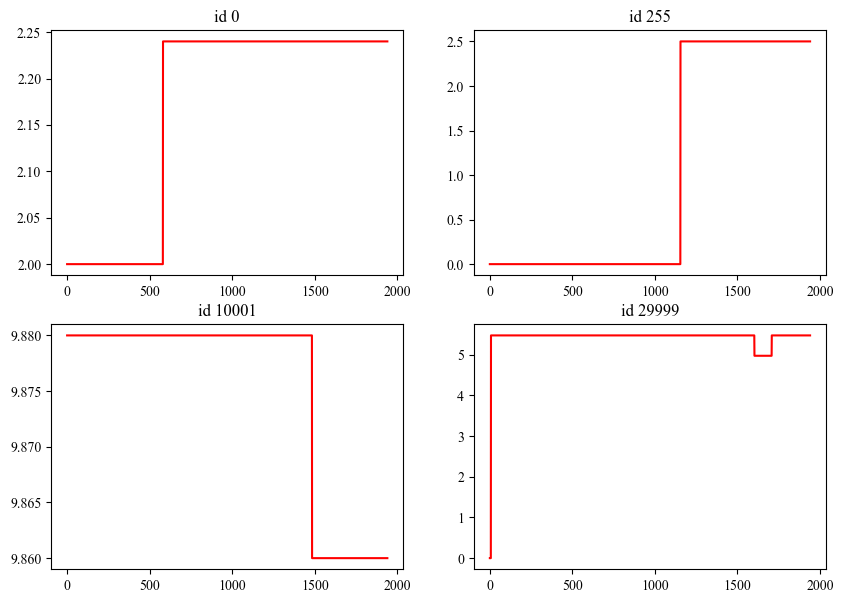

In [137]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize=(10,7))
id = 0
ax[0,0].plot(range(1941), sell_price[id], color = 'red')
ax[0,0].set_title(f'id {id}')

id = 255
ax[0,1].plot(range(1941), sell_price[id], color = 'red')
ax[0,1].set_title(f'id {id}')

id = 10001
ax[1,0].plot(range(1941), sell_price[id], color = 'red')
ax[1,0].set_title(f'id {id}')

id = 29999
ax[1,1].plot(range(1941), sell_price[id], color = 'red')
ax[1,1].set_title(f'id {id}')

plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 10

### 简单尝试一个单属性时序预测模型——》ARIMA相当糟糕，完全捕捉不到销售额的变化

d:\APP\python\3.7.0\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\APP\python\3.7.0\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\APP\python\3.7.0\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\APP\python\3.7.0\lib\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


Text(0.5, 1.0, 'ARIMA for id 5')

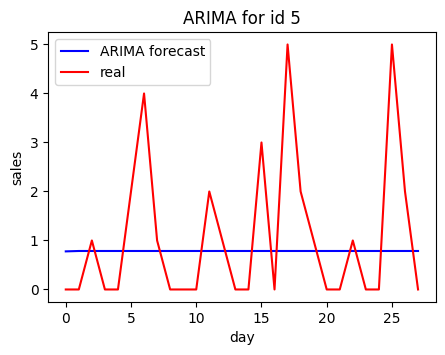

In [10]:
# 使用ARIMA实验
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

id = 5
ts = sales.iloc[id,6:-28].astype(int)
model = ARIMA(ts, order=(1, 1, 1))
results = model.fit()
forecast = results.forecast(steps=28)

import matplotlib.pyplot as plt
plt.figure(figsize=(5,3.5))
plt.plot(range(28), forecast.values, color='blue')
plt.plot(range(28), see(id, True, False, True), color='red')
plt.legend(['ARIMA forecast', 'real'])
plt.xlabel('day')
plt.ylabel('sales')
plt.title(f'ARIMA for id {id}')

d:\APP\python\3.7.0\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\APP\python\3.7.0\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\APP\python\3.7.0\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\APP\python\3.7.0\lib\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


Text(0.5, 1.0, 'ARIMA for id 100')

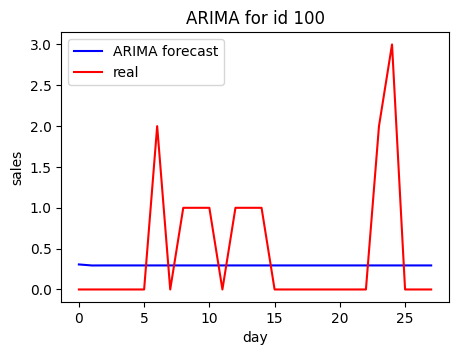

In [11]:
id = 100
ts = sales.iloc[id,6:-28].astype(int)
model = ARIMA(ts, order=(1, 1, 1))#p、d、q
results = model.fit()
forecast = results.forecast(steps=28)

import matplotlib.pyplot as plt
plt.figure(figsize=(5,3.5))
plt.plot(range(28), forecast.values, color='blue')
plt.plot(range(28), see(id, True, False, True), color='red')
plt.legend(['ARIMA forecast', 'real'])
plt.xlabel('day')
plt.ylabel('sales')
plt.title(f'ARIMA for id {id}')

### 构建时间特征

In [147]:
import pandas as pd

# 提取日期是周几、月份、年份、事件
weekday = calendar['wday']
month = calendar['month']
year = calendar['year']

# 提取不同城市的补贴状态 “0”｜“1”
CA = calendar['snap_CA']
TX = calendar['snap_TX']
WI = calendar['snap_WI']

# 每天的促销活动/主题
## 首先进行整数编码，然后缺失值填补为0
calendar_df = pd.read_csv('./data/calendar.csv')

encoded, _ = pd.factorize(calendar_df['event_name_1'], na_sentinel=-1)
encoded[encoded != -1] += 1
encoded[encoded == -1] = 0
eventname1 = encoded

encoded, _ = pd.factorize(calendar_df['event_type_1'], na_sentinel=-1)
encoded[encoded != -1] += 1
encoded[encoded == -1] = 0
eventtype1 = encoded

encoded, _ = pd.factorize(calendar_df['event_name_2'], na_sentinel=-1)
encoded[encoded != -1] += 1
encoded[encoded == -1] = 0
eventname2 = encoded

encoded, _ = pd.factorize(calendar_df['event_type_2'], na_sentinel=-1)
encoded[encoded != -1] += 1
encoded[encoded == -1] = 0
eventtype2 = encoded

### 存储时间特征 (避免存储错误的临时变量，导致文件被破坏，因此注释)

In [156]:
# with open('./data/weekday.pickle', 'wb') as f:
#     pickle.dump(weekday[:1941], f)

# with open('./data/month.pickle', 'wb') as f:
#     pickle.dump(month[:1941], f)

# with open('./data/year.pickle', 'wb') as f:
#     pickle.dump(year[:1941], f)

# with open('./data/CA.pickle', 'wb') as f:
#     pickle.dump(CA[:1941], f)

# with open('./data/TX.pickle', 'wb') as f:
#     pickle.dump(TX[:1941], f)

# with open('./data/WI.pickle', 'wb') as f:
#     pickle.dump(WI[:1941], f)

# with open('./data/eventname1.pickle', 'wb') as f:
#     pickle.dump(eventname1[:1941], f)

# with open('./data/eventtype1.pickle', 'wb') as f:
#     pickle.dump(eventtype1[:1941], f)

# with open('./data/eventname2.pickle', 'wb') as f:
#     pickle.dump(eventname2[:1941], f)

# with open('./data/eventtype2.pickle', 'wb') as f:
#     pickle.dump(eventtype2[:1941], f)

### 提取时序特征

In [53]:
import pickle
with open('./data/eventname1.pickle', 'rb') as f:
    eventname1 = pickle.load(f)

with open('./data/eventname2.pickle', 'rb') as f:
    eventname2 = pickle.load(f)

with open('./data/eventtype1.pickle', 'rb') as f:
    eventtype1 = pickle.load(f)

with open('./data/eventtype2.pickle', 'rb') as f:
    eventtype2 = pickle.load(f)

with open('./data/CA.pickle', 'rb') as f:
    snap_CA = pickle.load(f)

with open('./data/TX.pickle', 'rb') as f:
    snap_TX = pickle.load(f)

with open('./data/WI.pickle', 'rb') as f:
    snap_WI = pickle.load(f)

with open('./data/weekday.pickle', 'rb') as f:
    weekday = pickle.load(f)

with open('./data/month.pickle', 'rb') as f:
    month = pickle.load(f)

with open('./data/year.pickle', 'rb') as f:
    year = pickle.load(f)

### 时间特征归一化

In [60]:
import numpy as np

eventname1 = np.array(eventname1)
eventname2 = np.array(eventname2)
eventtype1 = np.array(eventtype1)
eventtype2 = np.array(eventtype2)
snap_CA = np.array(snap_CA)
snap_TX = np.array(snap_TX)
snap_WI = np.array(snap_WI)
weekday = np.array(weekday)
month = np.array(month)
year = np.array(year)

eventname1 = (eventname1 - min(eventname1)) / (max(eventname1) - min(eventname1))
eventname1 = np.nan_to_num(eventname1, nan=0)

eventname2 = (eventname2 - min(eventname2)) / (max(eventname2) - min(eventname2))
eventname2 = np.nan_to_num(eventname2, nan=0)

eventtype1 = (eventtype1 - min(eventtype1)) / (max(eventtype1) - min(eventtype1))
eventtype1 = np.nan_to_num(eventtype1, nan=0)

eventtype2 = (eventtype2 - min(eventtype2)) / (max(eventtype2) - min(eventtype2))
eventtype2 = np.nan_to_num(eventtype2, nan=0)

snap_CA = (snap_CA - min(snap_CA)) / (max(snap_CA) - min(snap_CA))
snap_CA = np.nan_to_num(snap_CA, nan=0)

snap_TX = (snap_TX - min(snap_TX)) / (max(snap_TX) - min(snap_TX))
snap_TX = np.nan_to_num(snap_TX, nan=0)

snap_WI = (snap_WI - min(snap_WI)) / (max(snap_WI) - min(snap_WI))
snap_WI = np.nan_to_num(snap_WI, nan=0)

month = (month - min(month)) / (max(month) - min(month))
month = np.nan_to_num(month, nan=0)

weekday = (weekday - min(weekday)) / (max(weekday) - min(weekday))
weekday = np.nan_to_num(weekday, nan=0)

year = (year - min(year)) / (max(year) - min(year))
year = np.nan_to_num(year, nan=0)

In [61]:
# with open('./data/weekday_norm.pickle', 'wb') as f:
#     pickle.dump(weekday[:1941], f)

# with open('./data/month_norm.pickle', 'wb') as f:
#     pickle.dump(month[:1941], f)

# with open('./data/year_norm.pickle', 'wb') as f:
#     pickle.dump(year[:1941], f)

# with open('./data/CA_norm.pickle', 'wb') as f:
#     pickle.dump(snap_CA[:1941], f)

# with open('./data/TX_norm.pickle', 'wb') as f:
#     pickle.dump(snap_TX[:1941], f)

# with open('./data/WI_norm.pickle', 'wb') as f:
#     pickle.dump(snap_WI[:1941], f)

# with open('./data/eventname1_norm.pickle', 'wb') as f:
#     pickle.dump(eventname1[:1941], f)

# with open('./data/eventtype1_norm.pickle', 'wb') as f:
#     pickle.dump(eventtype1[:1941], f)

# with open('./data/eventname2_norm.pickle', 'wb') as f:
#     pickle.dump(eventname2[:1941], f)

# with open('./data/eventtype2_norm.pickle', 'wb') as f:
#     pickle.dump(eventtype2[:1941], f)

In [15]:
# 获取需要的销售量数据
y = sales.iloc[:, 6:-28].values.reshape(-1).tolist()

In [54]:
import numpy as np
# 使用 Numpy 的 tile 函数复制数组
X_en1 = np.tile(eventname1[:-28], len(sales)).reshape(-1).tolist()
X_et1 = np.tile(eventtype1[:-28], len(sales)).reshape(-1).tolist()
X_en2 = np.tile(eventname2[:-28], len(sales)).reshape(-1).tolist()
X_et2 = np.tile(eventtype2[:-28], len(sales)).reshape(-1).tolist()
X_yer = np.tile(year[:-28], len(sales)).reshape(-1).tolist()
X_mon = np.tile(month[:-28], len(sales)).reshape(-1).tolist()
X_wkd = np.tile(weekday[:-28], len(sales)).reshape(-1).tolist()
X_CA = np.tile(snap_CA[:-28], len(sales)).reshape(-1).tolist()
X_TX = np.tile(snap_TX[:-28], len(sales)).reshape(-1).tolist()
X_WI = np.tile(snap_WI[:-28], len(sales)).reshape(-1).tolist()

In [73]:
import pandas as pd
X_pri = pd.DataFrame(sell_price[:,:-28])
X_pri = X_pri.values.reshape(-1).tolist()

In [35]:
# 选择需要编码的列
cols_to_encode = ['dept_id', 'cat_id', 'store_id', 'state_id']

# 遍历需要编码的列，使用 factorize 函数进行编码
for col in cols_to_encode:
    sales[col], _ = pd.factorize(sales[col])

In [ ]:
# X_dpt = []
# for i in range(len(sales)):
#     X_dpt += [sales.iloc[i]['dept_id']] * 1913
# 效率太低

In [56]:
# 定义一个函数，用于将每个 dept_id 值重复 1913 次
import numpy as np
def repeat_dept_id(row):
    return [row['dept_id']] * 1913
X_dpt = sales.apply(repeat_dept_id, axis=1)
X_dpt = np.concatenate(X_dpt.values).tolist()

def repeat_cat_id(row):
    return [row['cat_id']] * 1913
X_cat = sales.apply(repeat_cat_id, axis=1)
X_cat = np.concatenate(X_cat.values).tolist()

def repeat_store_id(row):
    return [row['store_id']] * 1913
X_sto = sales.apply(repeat_store_id, axis=1)
X_sto = np.concatenate(X_sto.values).tolist()

def repeat_state_id(row):
    return [row['state_id']] * 1913
X_sta = sales.apply(repeat_state_id, axis=1)
X_sta = np.concatenate(X_sta.values).tolist()

In [75]:
import pandas as pd

X = pd.DataFrame([])
X['en1'] = X_en1
X['en2'] = X_en2
X['et1'] = X_et1
X['et2'] = X_et2
X['yer'] = X_yer
X['mon'] = X_mon
X['wkd'] = X_wkd
X['CA'] = X_CA
X['TX'] = X_TX
X['WI'] = X_WI
X['pri'] = X_pri
X['dpt'] = X_dpt
X['cat'] = X_cat
X['sto'] = X_sto
X['sta'] = X_sta

# 存储构建的用于测试非循环时序预测模型的数据集

In [84]:
# X.to_csv('./data/X_non_recursive.csv')
# import pickle
# with open('./data/Y_non_recursive.pickle', 'wb') as f:
#     pickle.dump(y, f)

# 读取

In [4]:
import pandas as pd
X = pd.read_csv('./data/X_non_recursive.csv', header = 0, index_col = None)

import pickle
with open('./data/Y_non_recursive.pickle', 'rb') as f:
    y = pickle.load(f)

In [5]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split

# 将数据集划分为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X[:5000000], y[:5000000], test_size=0.2, random_state=42)

[1]	training's rmse: 3.55133	valid_1's rmse: 3.61564
Training until validation scores don't improve for 50 rounds
[2]	training's rmse: 3.53848	valid_1's rmse: 3.60313
[3]	training's rmse: 3.53229	valid_1's rmse: 3.59708
[4]	training's rmse: 3.5236	valid_1's rmse: 3.58849
[5]	training's rmse: 3.51613	valid_1's rmse: 3.58094
[6]	training's rmse: 3.51147	valid_1's rmse: 3.5764
[7]	training's rmse: 3.50435	valid_1's rmse: 3.56937
[8]	training's rmse: 3.49959	valid_1's rmse: 3.56502
[9]	training's rmse: 3.49434	valid_1's rmse: 3.55971
[10]	training's rmse: 3.48873	valid_1's rmse: 3.55416
[11]	training's rmse: 3.48566	valid_1's rmse: 3.55117
[12]	training's rmse: 3.48077	valid_1's rmse: 3.54647
[13]	training's rmse: 3.47676	valid_1's rmse: 3.54242
[14]	training's rmse: 3.47277	valid_1's rmse: 3.53868
[15]	training's rmse: 3.46913	valid_1's rmse: 3.53516
[16]	training's rmse: 3.46617	valid_1's rmse: 3.53203
[17]	training's rmse: 3.46262	valid_1's rmse: 3.52896
[18]	training's rmse: 3.46008	va

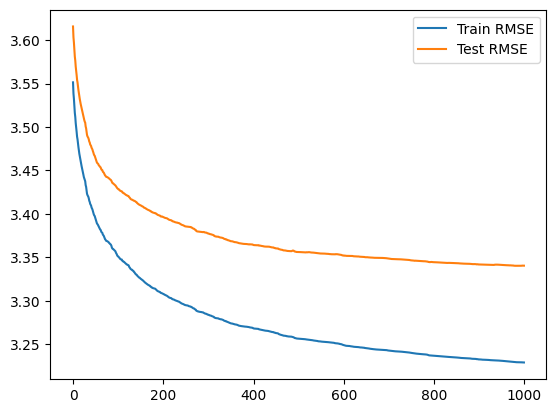

In [72]:
# 定义 LightGBM 模型参数
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'n_jobs': -1
}

# 将数据集转换为 LightGBM 的数据格式
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

# 训练模型，并记录训练过程中的性能
evals_result = {}
model = lgb.train(params, train_data, num_boost_round=1000, valid_sets=[train_data, test_data], early_stopping_rounds=50, evals_result=evals_result)

# 评估模型
y_pred = model.predict(X_test, num_iteration=model.best_iteration)

# 计算相关系数
from scipy.stats import pearsonr
correlation, _ = pearsonr(y_test, y_pred)
print('Correlation Coefficient:', correlation)

# 绘制训练曲线
import matplotlib.pyplot as plt
train_rmse = evals_result['training']['rmse']
test_rmse = evals_result['valid_1']['rmse']
plt.plot(train_rmse, label='Train RMSE')
plt.plot(test_rmse, label='Test RMSE')
plt.legend()
plt.show()

# evaluation

In [27]:
y_eval = sales.iloc[:,-28:].values.reshape(-1).tolist()

In [28]:
import numpy as np
# 使用 Numpy 的 tile 函数复制数组
X_en1 = np.tile(eventname1[-28:], len(sales)).reshape(-1).tolist()
X_et1 = np.tile(eventtype1[-28:], len(sales)).reshape(-1).tolist()
X_en2 = np.tile(eventname2[-28:], len(sales)).reshape(-1).tolist()
X_et2 = np.tile(eventtype2[-28:], len(sales)).reshape(-1).tolist()
X_yer = np.tile(year[-28:], len(sales)).reshape(-1).tolist()
X_mon = np.tile(month[-28:], len(sales)).reshape(-1).tolist()
X_wkd = np.tile(weekday[-28:], len(sales)).reshape(-1).tolist()
X_CA = np.tile(snap_CA[-28:], len(sales)).reshape(-1).tolist()
X_TX = np.tile(snap_TX[-28:], len(sales)).reshape(-1).tolist()
X_WI = np.tile(snap_WI[-28:], len(sales)).reshape(-1).tolist()

In [42]:
# 选择需要编码的列
cols_to_encode = ['dept_id', 'cat_id', 'store_id', 'state_id']

# 遍历需要编码的列，使用 factorize 函数进行编码
for col in cols_to_encode:
    sales[col], _ = pd.factorize(sales[col])

In [43]:
# 定义一个函数，用于将每个 dept_id 值重复 28 次
import numpy as np
def repeat_dept_id(row):
    return [row['dept_id']] * 28
X_dpt = sales.apply(repeat_dept_id, axis=1)
X_dpt = np.concatenate(X_dpt.values).tolist()

def repeat_cat_id(row):
    return [row['cat_id']] * 28
X_cat = sales.apply(repeat_cat_id, axis=1)
X_cat = np.concatenate(X_cat.values).tolist()

def repeat_store_id(row):
    return [row['store_id']] * 28
X_sto = sales.apply(repeat_store_id, axis=1)
X_sto = np.concatenate(X_sto.values).tolist()

def repeat_state_id(row):
    return [row['state_id']] * 28
X_sta = sales.apply(repeat_state_id, axis=1)
X_sta = np.concatenate(X_sta.values).tolist()

In [30]:
import pandas as pd
X_pri = pd.DataFrame(sell_price[:,-28:])
X_pri = X_pri.values.reshape(-1).tolist()

In [44]:
import pandas as pd

X_eval = pd.DataFrame([])
X_eval['en1'] = X_en1
X_eval['en2'] = X_en2
X_eval['et1'] = X_et1
X_eval['et2'] = X_et2
X_eval['yer'] = X_yer
X_eval['mon'] = X_mon
X_eval['wkd'] = X_wkd
X_eval['CA'] = X_CA
X_eval['TX'] = X_TX
X_eval['WI'] = X_WI
X_eval['pri'] = X_pri
X_eval['dpt'] = X_dpt
X_eval['cat'] = X_cat
X_eval['sto'] = X_sto
X_eval['sta'] = X_sta

In [46]:
X_eval.to_csv('./data/X_non_recursive_eval.csv')

import pickle
with open('./data/Y_non_recursive_eval.csv', 'wb') as f:
    pickle.dump(y_eval, f)

In [45]:
X_eval

,en1,en2,et1,et2,yer,mon,wkd,CA,TX,WI,pri,dpt,cat,sto,sta
0,0,0,0,0,2016,4,3,0,0,0,2.24,0,0,0,0
1,0,0,0,0,2016,4,4,0,0,0,2.24,0,0,0,0
2,0,0,0,0,2016,4,5,0,0,0,2.24,0,0,0,0
3,0,0,0,0,2016,4,6,0,0,0,2.24,0,0,0,0
4,0,0,0,0,2016,4,7,0,0,0,2.24,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
853715,0,0,0,0,2016,5,5,0,0,0,5.94,6,2,9,2
853716,0,0,0,0,2016,5,6,0,0,0,5.94,6,2,9,2
853717,0,0,0,0,2016,5,7,0,0,0,5.94,6,2,9,2
853718,0,0,0,0,2016,5,1,0,0,0,5.94,6,2,9,2


In [73]:
y_pred = model.predict(X_eval, num_iteration=model.best_iteration)

In [76]:
import numpy as np
y_pred = y_pred.reshape(int(len(y_pred)/28), 28)
# y_eval = np.array(y_eval)
# y_eval = y_eval.reshape(int(len(y_eval)/28), 28)

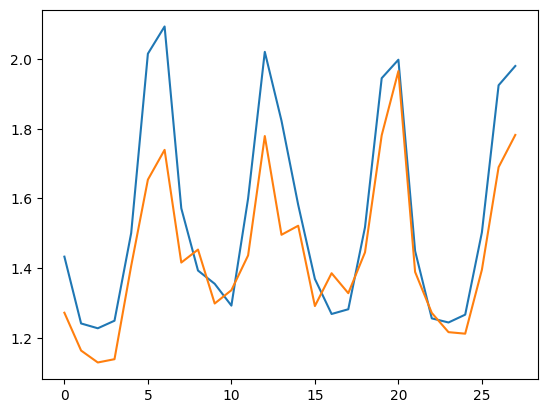

In [77]:
plt.plot(range(28), y_pred.mean(axis=0))
plt.plot(range(28), y_eval.mean(axis=0))

# 再次测试其他基本的非循环方法
即当作基本的回归任务判断

In [ ]:
from lazypredict.Supervised import LazyRegressor

# 创建 LazyRegressor 模型
reg = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None)

# 训练模型并输出性能指标
models, predictions = reg.fit(X_train, X_test, y_train, y_test)
print(models)

In [5]:
sales.describe()

,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
count,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,...,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000
mean,1.070220,1.041292,0.780026,0.833454,0.627944,0.958052,0.918662,1.244080,1.073663,0.838701,...,1.445490,1.781174,1.965267,1.389374,1.271794,1.216661,1.212299,1.395605,1.689669,1.782158
std,5.126689,5.365468,3.667454,4.415141,3.379344,4.785947,5.059495,6.617729,5.917204,4.206199,...,3.656824,4.426550,4.706284,3.313292,3.126178,3.000348,2.955910,3.514318,4.089208,4.284356
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,2.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000
max,360.000000,436.000000,207.000000,323.000000,296.000000,314.000000,316.000000,370.000000,385.000000,353.000000,...,143.000000,156.000000,187.000000,98.000000,90.000000,77.000000,84.000000,110.000000,156.000000,117.000000


# LSTM

In [74]:
import pickle
with open('./data/eventname1_norm.pickle', 'rb') as f:
    eventname1 = pickle.load(f)

with open('./data/eventname2_norm.pickle', 'rb') as f:
    eventname2 = pickle.load(f)

with open('./data/eventtype1_norm.pickle', 'rb') as f:
    eventtype1 = pickle.load(f)

with open('./data/eventtype2_norm.pickle', 'rb') as f:
    eventtype2 = pickle.load(f)

with open('./data/CA_norm.pickle', 'rb') as f:
    snap_CA = pickle.load(f)

with open('./data/TX_norm.pickle', 'rb') as f:
    snap_TX = pickle.load(f)

with open('./data/WI_norm.pickle', 'rb') as f:
    snap_WI = pickle.load(f)

with open('./data/weekday_norm.pickle', 'rb') as f:
    weekday = pickle.load(f)

with open('./data/month_norm.pickle', 'rb') as f:
    month = pickle.load(f)

with open('./data/year_norm.pickle', 'rb') as f:
    year = pickle.load(f)

import pickle
with open('./data/price_norm.pickle', 'rb') as f:
    sell_price = pickle.load(f)

import pandas as pd
sales = pd.read_csv("./data/sales.csv")

### 依次训练LSTM模型，n_time_step设置较大的值

In [172]:
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm

class SigLSTM(nn.Module):
    def __init__(self, n_time_steps=5, n_features=12, n_outputs=1, lstm_units=32, dropout_rate=0.2):
        super(SigLSTM, self).__init__()
        self.n_time_steps = n_time_steps
        self.n_features = n_features
        self.n_outputs = n_outputs
        self.lstm_units = lstm_units
        self.dropout_rate = dropout_rate
        self.lstm = nn.LSTM(input_size=n_features, hidden_size=lstm_units, num_layers=1, batch_first=True)
        self.dropout = nn.Dropout(p=dropout_rate)
        self.fc = nn.Linear(lstm_units, n_outputs)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        y_pred = self.fc(lstm_out[:, -1, :])
        return y_pred

    def fit(self, X, y, epochs=50, batch_size=32, learning_rate=0.001):
        # 将数据转换为张量
        X = torch.tensor(X, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.float32)
        # 训练模型
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)
        
        for epoch in range(epochs):
            for i in range(0, len(X) - batch_size, batch_size):
                batch_x = X[i:i+batch_size].view(batch_size, self.n_time_steps, self.n_features)
                batch_y = y[i:i+batch_size]
                y_pred = self.forward(batch_x)
                loss = criterion(y_pred, batch_y)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            print(f'_________epoch {epoch} {loss.item()}: _________')

    def predict(self, X):
        # 转换数据类型
        X = torch.tensor(X).float()
        # 预测
        y_pred = self.forward(X).detach().numpy()
        return y_pred

In [183]:
class SigLSTM(nn.Module):
    def __init__(self, n_time_steps=5, n_features=12, n_classes=2, lstm_units=32, dropout_rate=0.2):
        super(SigLSTM, self).__init__()
        self.n_time_steps = n_time_steps
        self.n_features = n_features
        self.n_classes = n_classes
        self.lstm_units = lstm_units
        self.dropout_rate = dropout_rate
        self.lstm = nn.LSTM(input_size=n_features, hidden_size=lstm_units, num_layers=1, batch_first=True)
        self.dropout = nn.Dropout(p=dropout_rate)
        self.fc = nn.Linear(lstm_units, n_classes)
        # self.softmax = nn.Softmax(dim=1)  # 添加softmax激活函数

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        y_pred = self.fc(lstm_out[:, -1, :])
        # y_pred = self.softmax(y_pred)  # 添加softmax激活函数
        return y_pred

    def fit(self, X, y, epochs=50, batch_size=32, learning_rate=0.001):
        # 将数据转换为张量
        X = torch.tensor(X, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.long)  # 修改标签的数据类型为long
        # 训练模型
        criterion = nn.CrossEntropyLoss()  # 修改损失函数为交叉熵损失函数
        optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)
        
        for epoch in range(epochs):
            for i in range(0, len(X) - batch_size, batch_size):
                batch_x = X[i:i+batch_size].view(batch_size, self.n_time_steps, self.n_features)
                batch_y = y[i:i+batch_size]
                y_pred = self.forward(batch_x)
                loss = criterion(y_pred, batch_y)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            print(f'_________epoch {epoch} {loss.item()}: _________')

    def predict(self, X):
        # 转换数据类型
        X = torch.tensor(X).float()
        # 预测
        y_pred = self.forward(X)
        y_pred = y_pred.argmax(dim=1).detach().numpy()  # 获取概率最高的类别
        return y_pred

_________epoch 0 1.3787246942520142: _________
_________epoch 1 1.377660870552063: _________
_________epoch 2 1.3675031661987305: _________
_________epoch 3 1.3600431680679321: _________
_________epoch 4 1.35747230052948: _________
_________epoch 5 1.3584988117218018: _________
_________epoch 6 1.357783317565918: _________
_________epoch 7 1.3635088205337524: _________
_________epoch 8 1.3620109558105469: _________
_________epoch 9 1.3677634000778198: _________
_________epoch 10 1.374675989151001: _________
_________epoch 11 1.3816512823104858: _________
_________epoch 12 1.3911254405975342: _________
_________epoch 13 1.3814903497695923: _________
_________epoch 14 1.3847815990447998: _________
_________epoch 15 1.3985209465026855: _________
_________epoch 16 1.410456657409668: _________
_________epoch 17 1.3946362733840942: _________
_________epoch 18 1.4061987400054932: _________
_________epoch 19 1.40733003616333: _________
_________epoch 20 1.3963419198989868: _________
_________e

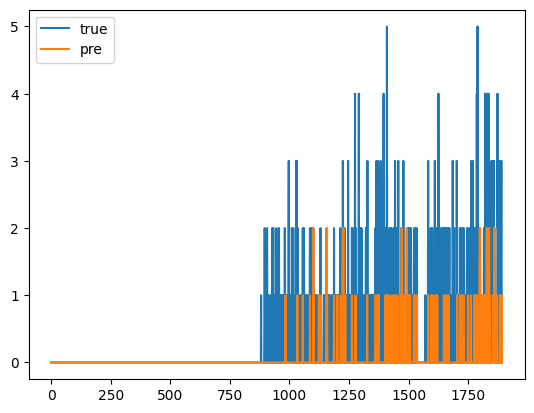

_________epoch 0 0.49208593368530273: _________
_________epoch 1 0.5034621357917786: _________
_________epoch 2 0.5018736720085144: _________
_________epoch 3 0.5005117058753967: _________
_________epoch 4 0.49854588508605957: _________
_________epoch 5 0.4953884184360504: _________
_________epoch 6 0.4906761050224304: _________
_________epoch 7 0.48593276739120483: _________
_________epoch 8 0.4839603900909424: _________
_________epoch 9 0.4824892282485962: _________
_________epoch 10 0.4811120927333832: _________
_________epoch 11 0.48182594776153564: _________
_________epoch 12 0.4820712208747864: _________
_________epoch 13 0.48262667655944824: _________
_________epoch 14 0.4825766980648041: _________
_________epoch 15 0.482383131980896: _________
_________epoch 16 0.4819658100605011: _________
_________epoch 17 0.4815623164176941: _________
_________epoch 18 0.4812713861465454: _________
_________epoch 19 0.48132315278053284: _________
_________epoch 20 0.48148947954177856: ______

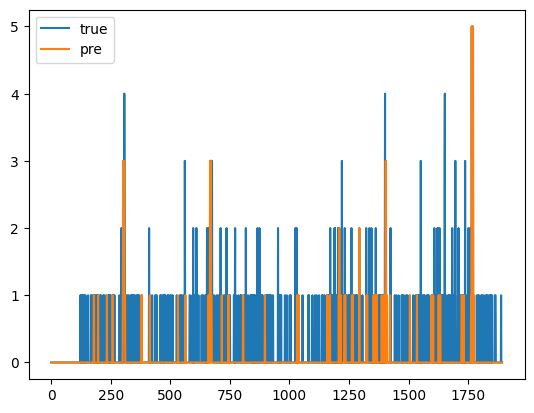

_________epoch 0 0.9872019290924072: _________
_________epoch 1 0.9256294965744019: _________
_________epoch 2 0.8958671689033508: _________
_________epoch 3 0.9130168557167053: _________
_________epoch 4 0.8763471245765686: _________
_________epoch 5 0.842768669128418: _________
_________epoch 6 0.8499441146850586: _________
_________epoch 7 0.8532004356384277: _________
_________epoch 8 0.8192336559295654: _________
_________epoch 9 0.814619779586792: _________
_________epoch 10 0.8081092238426208: _________
_________epoch 11 0.8072631359100342: _________
_________epoch 12 0.8052663803100586: _________
_________epoch 13 0.8037181496620178: _________
_________epoch 14 0.80158931016922: _________
_________epoch 15 0.796884298324585: _________
_________epoch 16 0.7788980603218079: _________
_________epoch 17 0.7870578765869141: _________
_________epoch 18 0.7970510125160217: _________
_________epoch 19 0.7782483100891113: _________
_________epoch 20 0.7897014617919922: _________
_______

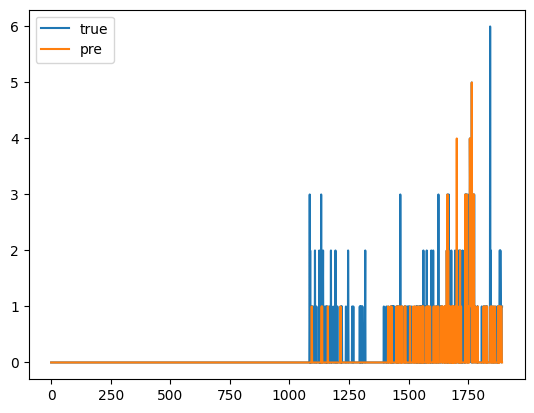

_________epoch 0 1.9525182247161865: _________
_________epoch 1 1.9362536668777466: _________
_________epoch 2 1.9305548667907715: _________
_________epoch 3 1.9269404411315918: _________
_________epoch 4 1.9260811805725098: _________
_________epoch 5 1.9249974489212036: _________
_________epoch 6 1.9208332300186157: _________
_________epoch 7 1.9051048755645752: _________
_________epoch 8 1.903165340423584: _________
_________epoch 9 1.9090518951416016: _________
_________epoch 10 1.8933384418487549: _________
_________epoch 11 1.8871984481811523: _________
_________epoch 12 1.8821567296981812: _________
_________epoch 13 1.8647465705871582: _________
_________epoch 14 1.8802093267440796: _________
_________epoch 15 1.870010495185852: _________
_________epoch 16 1.8622971773147583: _________
_________epoch 17 1.8467531204223633: _________
_________epoch 18 1.8349339962005615: _________
_________epoch 19 1.8233002424240112: _________
_________epoch 20 1.809572458267212: _________
_____

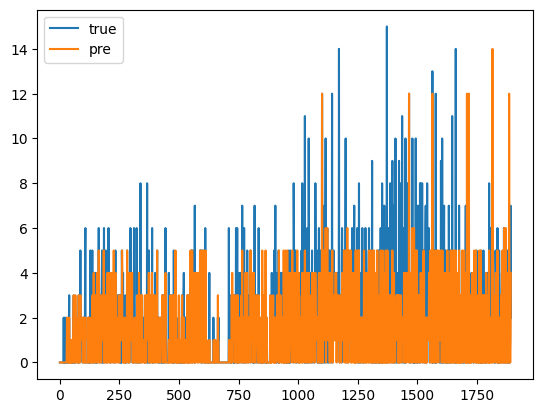

_________epoch 0 1.4694236516952515: _________
_________epoch 1 1.4596368074417114: _________
_________epoch 2 1.457723617553711: _________
_________epoch 3 1.457678198814392: _________
_________epoch 4 1.4564380645751953: _________
_________epoch 5 1.4557698965072632: _________
_________epoch 6 1.450976014137268: _________
_________epoch 7 1.4462674856185913: _________
_________epoch 8 1.4545778036117554: _________
_________epoch 9 1.44056236743927: _________
_________epoch 10 1.4415494203567505: _________
_________epoch 11 1.4459666013717651: _________
_________epoch 12 1.4491634368896484: _________
_________epoch 13 1.4529105424880981: _________
_________epoch 14 1.4549654722213745: _________
_________epoch 15 1.4501434564590454: _________
_________epoch 16 1.447436809539795: _________
_________epoch 17 1.4470349550247192: _________
_________epoch 18 1.446668267250061: _________
_________epoch 19 1.4463797807693481: _________
_________epoch 20 1.4459991455078125: _________
_________

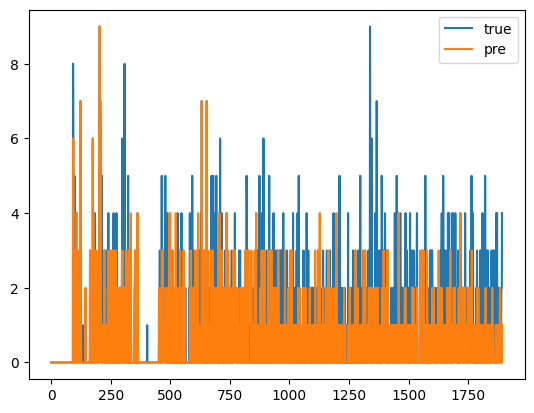

_________epoch 0 1.3006969690322876: _________
_________epoch 1 1.289849877357483: _________
_________epoch 2 1.286118745803833: _________
_________epoch 3 1.2862621545791626: _________
_________epoch 4 1.2878222465515137: _________
_________epoch 5 1.2897865772247314: _________
_________epoch 6 1.2908217906951904: _________
_________epoch 7 1.2889187335968018: _________
_________epoch 8 1.2895089387893677: _________
_________epoch 9 1.296183466911316: _________
_________epoch 10 1.2966413497924805: _________
_________epoch 11 1.2942646741867065: _________
_________epoch 12 1.2913556098937988: _________
_________epoch 13 1.2806490659713745: _________
_________epoch 14 1.2750403881072998: _________
_________epoch 15 1.2721331119537354: _________
_________epoch 16 1.2699353694915771: _________
_________epoch 17 1.2694865465164185: _________
_________epoch 18 1.2665492296218872: _________
_________epoch 19 1.2640836238861084: _________
_________epoch 20 1.2610756158828735: _________
_____

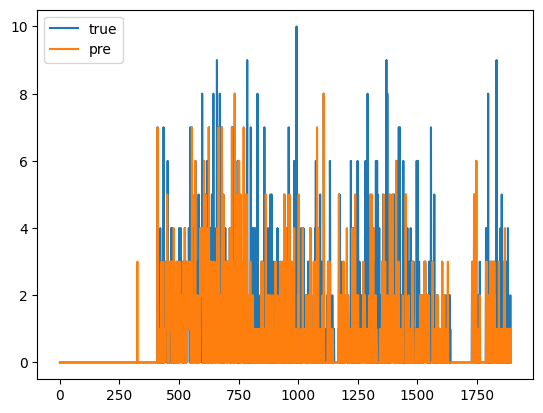

_________epoch 0 0.7082142233848572: _________
_________epoch 1 0.7070443034172058: _________
_________epoch 2 0.7039576768875122: _________
_________epoch 3 0.7036741971969604: _________
_________epoch 4 0.7038793563842773: _________
_________epoch 5 0.7045623660087585: _________
_________epoch 6 0.7055763602256775: _________
_________epoch 7 0.7067604660987854: _________
_________epoch 8 0.7077035903930664: _________
_________epoch 9 0.7090843319892883: _________
_________epoch 10 0.7111047506332397: _________
_________epoch 11 0.7099936604499817: _________
_________epoch 12 0.7098466157913208: _________
_________epoch 13 0.7095032334327698: _________
_________epoch 14 0.7097916603088379: _________
_________epoch 15 0.7110686898231506: _________
_________epoch 16 0.7104536890983582: _________
_________epoch 17 0.7107313871383667: _________
_________epoch 18 0.7109904885292053: _________
_________epoch 19 0.7244230508804321: _________
_________epoch 20 0.7180166840553284: _________
__

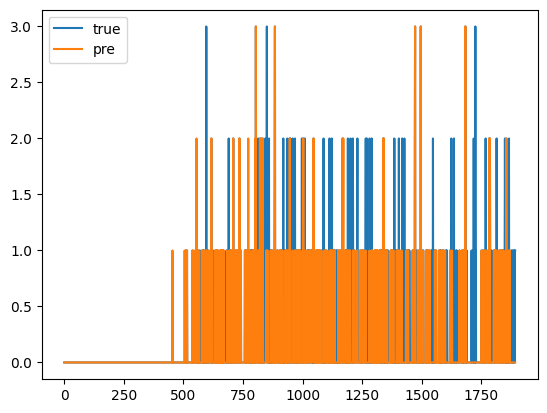

_________epoch 0 3.154125690460205: _________
_________epoch 1 3.142070770263672: _________
_________epoch 2 3.1207032203674316: _________
_________epoch 3 3.0784952640533447: _________
_________epoch 4 3.0703680515289307: _________
_________epoch 5 3.0636534690856934: _________
_________epoch 6 3.058065891265869: _________
_________epoch 7 3.053528308868408: _________
_________epoch 8 3.051974058151245: _________
_________epoch 9 3.0477545261383057: _________
_________epoch 10 3.0400519371032715: _________
_________epoch 11 3.030975818634033: _________
_________epoch 12 3.0238025188446045: _________
_________epoch 13 3.00970721244812: _________
_________epoch 14 3.002629280090332: _________
_________epoch 15 2.996250629425049: _________
_________epoch 16 2.989521026611328: _________
_________epoch 17 2.98596453666687: _________
_________epoch 18 2.9808545112609863: _________
_________epoch 19 2.977397918701172: _________
_________epoch 20 2.9726221561431885: _________
_________epoch 2

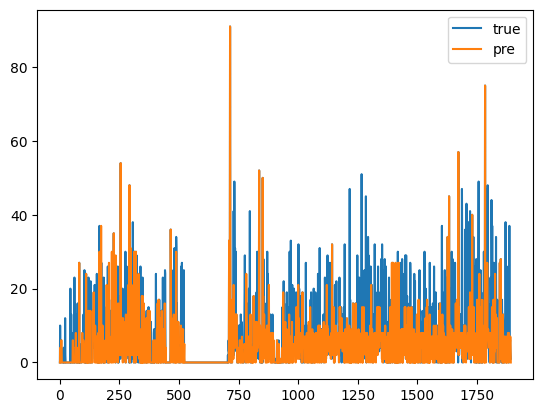

_________epoch 0 1.2342209815979004: _________
_________epoch 1 1.1747320890426636: _________
_________epoch 2 1.1691970825195312: _________
_________epoch 3 1.1714565753936768: _________
_________epoch 4 1.1783050298690796: _________
_________epoch 5 1.1998313665390015: _________
_________epoch 6 1.2013328075408936: _________
_________epoch 7 1.2116810083389282: _________
_________epoch 8 1.2178436517715454: _________
_________epoch 9 1.2190611362457275: _________
_________epoch 10 1.2192617654800415: _________
_________epoch 11 1.2195537090301514: _________
_________epoch 12 1.2211134433746338: _________
_________epoch 13 1.223264455795288: _________
_________epoch 14 1.2255117893218994: _________
_________epoch 15 1.2278478145599365: _________
_________epoch 16 1.2308130264282227: _________
_________epoch 17 1.2342822551727295: _________
_________epoch 18 1.2384620904922485: _________
_________epoch 19 1.2514848709106445: _________
_________epoch 20 1.272389531135559: _________
____

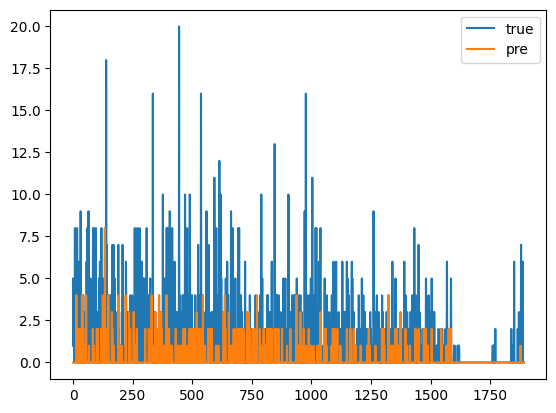

_________epoch 0 1.0835720300674438: _________
_________epoch 1 1.0805963277816772: _________
_________epoch 2 1.0760396718978882: _________
_________epoch 3 1.073265552520752: _________
_________epoch 4 1.0708441734313965: _________
_________epoch 5 1.0683540105819702: _________
_________epoch 6 1.065613031387329: _________
_________epoch 7 1.0626193284988403: _________
_________epoch 8 1.0594253540039062: _________
_________epoch 9 1.056059718132019: _________
_________epoch 10 1.0524463653564453: _________
_________epoch 11 1.0486270189285278: _________
_________epoch 12 1.0443941354751587: _________
_________epoch 13 1.0420012474060059: _________
_________epoch 14 1.034314751625061: _________
_________epoch 15 1.0345749855041504: _________
_________epoch 16 1.028428316116333: _________
_________epoch 17 1.0316638946533203: _________
_________epoch 18 1.0240411758422852: _________
_________epoch 19 1.0222351551055908: _________
_________epoch 20 1.030629277229309: _________
________

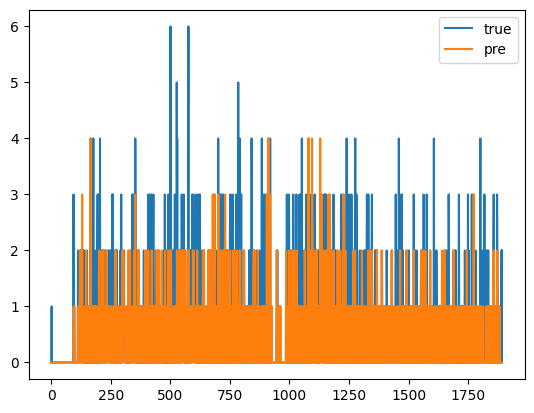

_________epoch 0 0.4841548800468445: _________
_________epoch 1 0.4941197335720062: _________
_________epoch 2 0.4927116334438324: _________
_________epoch 3 0.49075189232826233: _________
_________epoch 4 0.48815619945526123: _________
_________epoch 5 0.4858281910419464: _________
_________epoch 6 0.4837540090084076: _________
_________epoch 7 0.4813964366912842: _________
_________epoch 8 0.47904857993125916: _________
_________epoch 9 0.4770432710647583: _________
_________epoch 10 0.47520890831947327: _________
_________epoch 11 0.4734272062778473: _________
_________epoch 12 0.4716017544269562: _________
_________epoch 13 0.4696861803531647: _________
_________epoch 14 0.46768325567245483: _________
_________epoch 15 0.4655967354774475: _________
_________epoch 16 0.46344369649887085: _________
_________epoch 17 0.4612772464752197: _________
_________epoch 18 0.45917290449142456: _________
_________epoch 19 0.45708611607551575: _________
_________epoch 20 0.454880952835083: _____

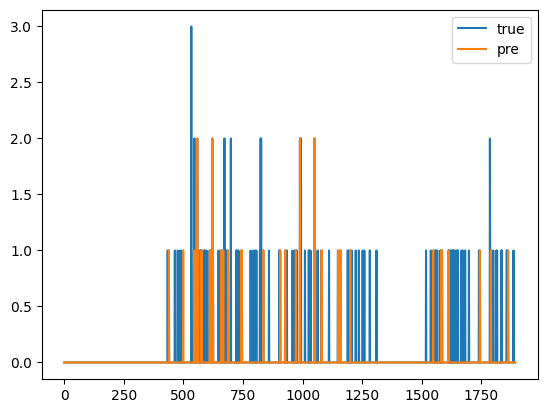

_________epoch 0 0.5206288695335388: _________
_________epoch 1 0.5179315805435181: _________
_________epoch 2 0.5205358266830444: _________
_________epoch 3 0.5218368172645569: _________
_________epoch 4 0.5223130583763123: _________
_________epoch 5 0.52244633436203: _________
_________epoch 6 0.5222203135490417: _________
_________epoch 7 0.5219621062278748: _________
_________epoch 8 0.5216064453125: _________
_________epoch 9 0.5206260085105896: _________
_________epoch 10 0.5199453830718994: _________
_________epoch 11 0.5194718837738037: _________
_________epoch 12 0.5192094445228577: _________
_________epoch 13 0.518740713596344: _________
_________epoch 14 0.5167270302772522: _________
_________epoch 15 0.5142800807952881: _________
_________epoch 16 0.5097893476486206: _________
_________epoch 17 0.5075184106826782: _________
_________epoch 18 0.5064376592636108: _________
_________epoch 19 0.5043482780456543: _________
_________epoch 20 0.5028237700462341: _________
________

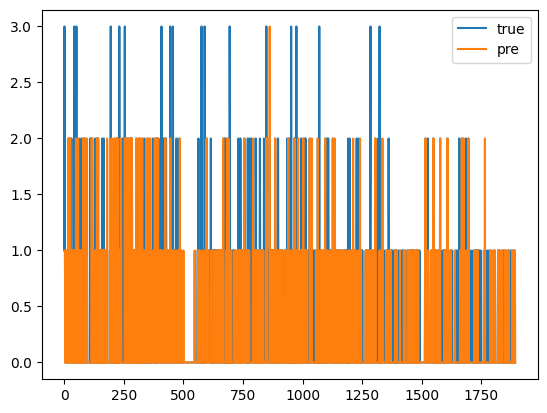

_________epoch 0 0.9186437129974365: _________
_________epoch 1 0.9045493602752686: _________
_________epoch 2 0.9003077745437622: _________
_________epoch 3 0.8980104327201843: _________
_________epoch 4 0.8969694375991821: _________
_________epoch 5 0.8964923024177551: _________
_________epoch 6 0.8960707783699036: _________
_________epoch 7 0.8955287337303162: _________
_________epoch 8 0.8951318264007568: _________
_________epoch 9 0.8952912092208862: _________
_________epoch 10 0.8957209587097168: _________
_________epoch 11 0.89521723985672: _________
_________epoch 12 0.8967474102973938: _________
_________epoch 13 0.8938363194465637: _________
_________epoch 14 0.902892529964447: _________
_________epoch 15 0.8975457549095154: _________
_________epoch 16 0.9028486013412476: _________
_________epoch 17 0.9006487727165222: _________
_________epoch 18 0.8877886533737183: _________
_________epoch 19 0.9041824340820312: _________
_________epoch 20 0.9113235473632812: _________
_____

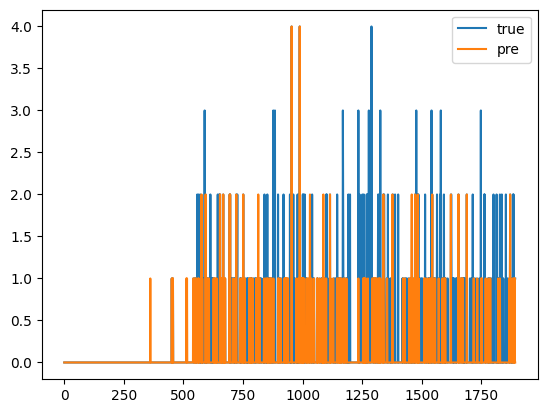

_________epoch 0 1.6804941892623901: _________
_________epoch 1 1.6622798442840576: _________
_________epoch 2 1.6598643064498901: _________
_________epoch 3 1.663981556892395: _________
_________epoch 4 1.6671009063720703: _________
_________epoch 5 1.6703640222549438: _________
_________epoch 6 1.6707042455673218: _________
_________epoch 7 1.6694540977478027: _________
_________epoch 8 1.6652365922927856: _________
_________epoch 9 1.6612343788146973: _________
_________epoch 10 1.657799243927002: _________
_________epoch 11 1.6608319282531738: _________
_________epoch 12 1.6630668640136719: _________
_________epoch 13 1.6647467613220215: _________
_________epoch 14 1.6650562286376953: _________
_________epoch 15 1.6633710861206055: _________
_________epoch 16 1.6612207889556885: _________
_________epoch 17 1.6544599533081055: _________
_________epoch 18 1.6509674787521362: _________
_________epoch 19 1.6460288763046265: _________
_________epoch 20 1.6417348384857178: _________
____

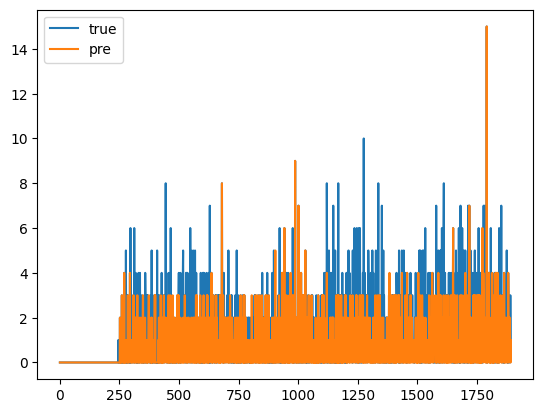

_________epoch 0 2.482776403427124: _________
_________epoch 1 2.5150201320648193: _________
_________epoch 2 2.5082285404205322: _________
_________epoch 3 2.516641616821289: _________
_________epoch 4 2.5259690284729004: _________
_________epoch 5 2.523458242416382: _________
_________epoch 6 2.510802745819092: _________
_________epoch 7 2.4903578758239746: _________
_________epoch 8 2.4712207317352295: _________
_________epoch 9 2.4550037384033203: _________
_________epoch 10 2.438627243041992: _________
_________epoch 11 2.4229135513305664: _________
_________epoch 12 2.409114122390747: _________
_________epoch 13 2.4003303050994873: _________
_________epoch 14 2.395397901535034: _________
_________epoch 15 2.3915934562683105: _________
_________epoch 16 2.3880138397216797: _________
_________epoch 17 2.3845913410186768: _________
_________epoch 18 2.3798999786376953: _________
_________epoch 19 2.372304916381836: _________
_________epoch 20 2.366058111190796: _________
_________ep

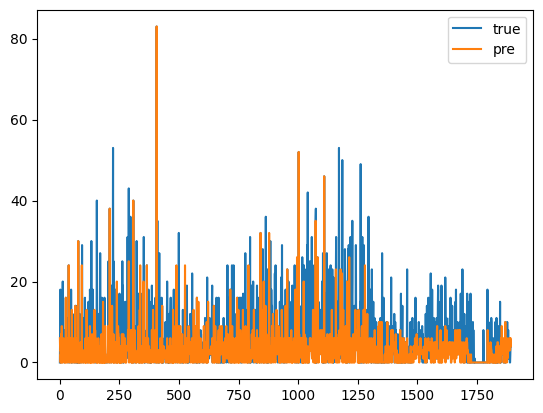

_________epoch 0 3.0327203273773193: _________
_________epoch 1 3.0181515216827393: _________
_________epoch 2 3.007267475128174: _________
_________epoch 3 2.9925780296325684: _________
_________epoch 4 2.9922592639923096: _________
_________epoch 5 2.985459089279175: _________
_________epoch 6 2.9794092178344727: _________
_________epoch 7 2.9866855144500732: _________
_________epoch 8 2.986811876296997: _________
_________epoch 9 2.982980251312256: _________
_________epoch 10 2.978649616241455: _________
_________epoch 11 2.974698543548584: _________
_________epoch 12 2.9743902683258057: _________
_________epoch 13 2.9682254791259766: _________
_________epoch 14 2.960216999053955: _________
_________epoch 15 2.9585211277008057: _________
_________epoch 16 2.957150936126709: _________
_________epoch 17 2.955266237258911: _________
_________epoch 18 2.952270269393921: _________
_________epoch 19 2.9506916999816895: _________
_________epoch 20 2.948225259780884: _________
_________epoc

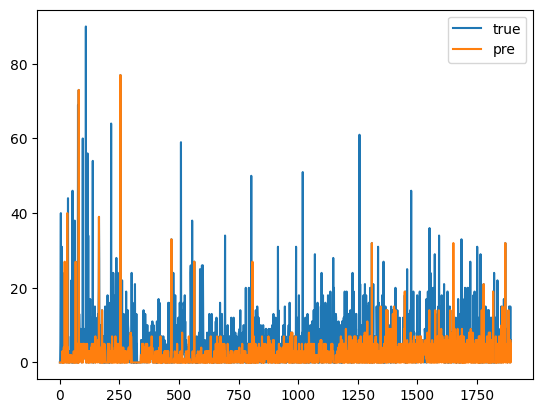

_________epoch 0 1.5064060688018799: _________
_________epoch 1 1.4690535068511963: _________
_________epoch 2 1.4714272022247314: _________
_________epoch 3 1.471644401550293: _________
_________epoch 4 1.471737027168274: _________
_________epoch 5 1.4720711708068848: _________
_________epoch 6 1.4726815223693848: _________
_________epoch 7 1.4730058908462524: _________
_________epoch 8 1.4731768369674683: _________
_________epoch 9 1.4740383625030518: _________
_________epoch 10 1.4706697463989258: _________
_________epoch 11 1.4705146551132202: _________
_________epoch 12 1.4670958518981934: _________
_________epoch 13 1.4618717432022095: _________
_________epoch 14 1.4402202367782593: _________
_________epoch 15 1.4423325061798096: _________
_________epoch 16 1.4497843980789185: _________
_________epoch 17 1.4526188373565674: _________
_________epoch 18 1.4518930912017822: _________
_________epoch 19 1.450137972831726: _________
_________epoch 20 1.4483877420425415: _________
_____

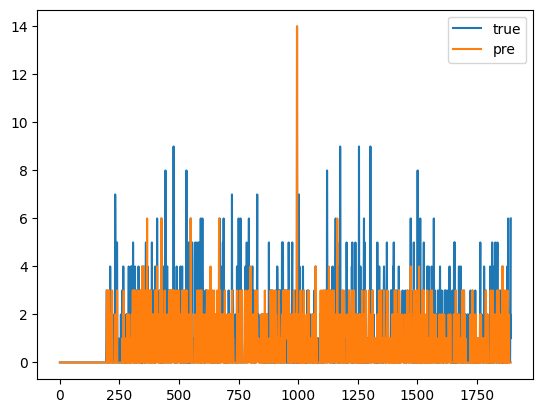

_________epoch 0 0.07185418903827667: _________
_________epoch 1 0.07503848522901535: _________
_________epoch 2 0.0739588662981987: _________
_________epoch 3 0.07204374670982361: _________
_________epoch 4 0.06993251293897629: _________
_________epoch 5 0.06787809729576111: _________
_________epoch 6 0.06610395014286041: _________
_________epoch 7 0.06455445289611816: _________
_________epoch 8 0.06313369423151016: _________
_________epoch 9 0.06178334727883339: _________
_________epoch 10 0.06047697365283966: _________
_________epoch 11 0.05926051735877991: _________
_________epoch 12 0.05797430872917175: _________
_________epoch 13 0.05685267597436905: _________
_________epoch 14 0.055454082787036896: _________
_________epoch 15 0.06960722804069519: _________
_________epoch 16 0.05143788084387779: _________
_________epoch 17 0.050846971571445465: _________
_________epoch 18 0.050240326672792435: _________
_________epoch 19 0.04963552951812744: _________
_________epoch 20 0.04907224

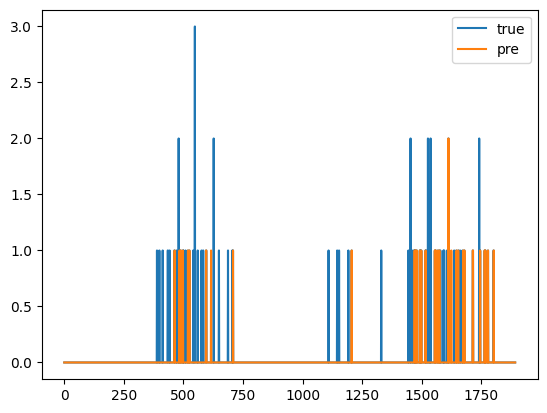

_________epoch 0 3.431548833847046: _________
_________epoch 1 3.3265366554260254: _________
_________epoch 2 3.2957589626312256: _________
_________epoch 3 3.2823426723480225: _________
_________epoch 4 3.262126922607422: _________
_________epoch 5 3.258143186569214: _________
_________epoch 6 3.252732753753662: _________
_________epoch 7 3.248598337173462: _________
_________epoch 8 3.2453906536102295: _________
_________epoch 9 3.2426748275756836: _________
_________epoch 10 3.242112636566162: _________
_________epoch 11 3.243713617324829: _________
_________epoch 12 3.246352195739746: _________
_________epoch 13 3.244722843170166: _________
_________epoch 14 3.247344970703125: _________
_________epoch 15 3.232574701309204: _________
_________epoch 16 3.234349250793457: _________
_________epoch 17 3.230173110961914: _________
_________epoch 18 3.220318555831909: _________
_________epoch 19 3.208322048187256: _________
_________epoch 20 3.2041499614715576: _________
_________epoch 21

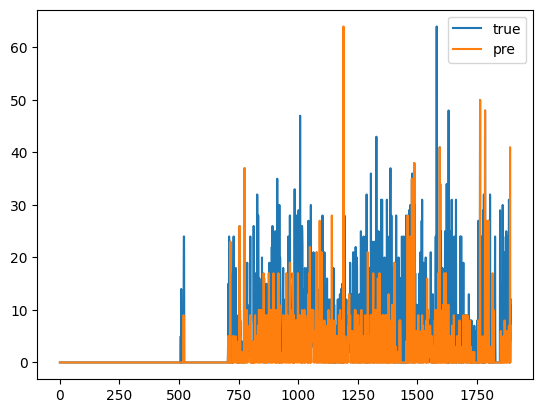

_________epoch 0 0.6749377250671387: _________
_________epoch 1 0.6694098711013794: _________
_________epoch 2 0.6709364652633667: _________
_________epoch 3 0.6717724204063416: _________
_________epoch 4 0.6725273728370667: _________
_________epoch 5 0.6731345057487488: _________
_________epoch 6 0.6738849878311157: _________
_________epoch 7 0.6720708012580872: _________
_________epoch 8 0.6741903424263: _________
_________epoch 9 0.6745336055755615: _________
_________epoch 10 0.6785979866981506: _________
_________epoch 11 0.6802093982696533: _________
_________epoch 12 0.6826899647712708: _________
_________epoch 13 0.6861878037452698: _________
_________epoch 14 0.6872788071632385: _________
_________epoch 15 0.6866912245750427: _________
_________epoch 16 0.6881702542304993: _________
_________epoch 17 0.6875202655792236: _________
_________epoch 18 0.6860554218292236: _________
_________epoch 19 0.6845725774765015: _________
_________epoch 20 0.6821513175964355: _________
_____

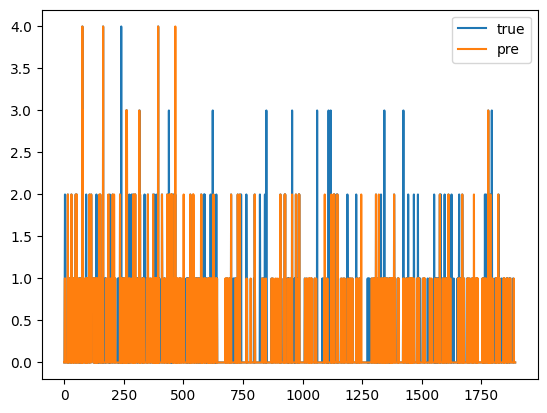

In [185]:
# 
n_time_steps = 20
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

TMP_X = pd.DataFrame([])

TMP_X['wkd'] = weekday[:-28]
TMP_X['mon'] = month[:-28]
TMP_X['yer'] = year[:-28]
TMP_X['en1'] = eventname1[:-28]
TMP_X['en2'] = eventname2[:-28]
TMP_X['et1'] = eventtype1[:-28]
TMP_X['et2'] = eventtype2[:-28]
TMP_X['CA'] = snap_CA[:-28]
TMP_X['TX'] = snap_TX[:-28]
TMP_X['WI'] = snap_WI[:-28]

EVAL_X = pd.DataFrame([])

EVAL_X['wkd'] = weekday[-50:]
EVAL_X['mon'] = month[-50:]
EVAL_X['yer'] = year[-50:]
EVAL_X['en1'] = eventname1[-50:]
EVAL_X['en2'] = eventname2[-50:]
EVAL_X['et1'] = eventtype1[-50:]
EVAL_X['et2'] = eventtype2[-50:]
EVAL_X['CA'] = snap_CA[-50:]
EVAL_X['TX'] = snap_TX[-50:]
EVAL_X['WI'] = snap_WI[-50:]

model = []
for j in range(20):
    # 制作RNN训练数据
    dataX = []
    dataY = []
    X_eval = []
    Y_eval = []

    TMP_X['pri'] = sell_price[j,:-28]
    TMP_X['sal'] = np.array(sales.iloc[j,6:-28].astype(float))
    # print(TMP_X['sal'])
    EVAL_X['pri'] = sell_price[j,-50:]
    EVAL_X['sal'] = np.array(sales.iloc[j,-50:].astype(float))
    # print(EVAL_X['sal'])
    y_eval = sales.iloc[j,-50:]
    y = sales.iloc[j,6:-28]

    for i in range(n_time_steps, len(y)):
        dataX.append(np.array(TMP_X.iloc[i - n_time_steps:i, :]))
        dataY.append(np.array(y[i]))
    dataX = np.array(dataX)
    dataY = np.array(dataY)
    TrueY = dataY
    
    y_min = min(dataY)
    y_max = max(dataY)
    # dataY = (dataY - y_min) / (y_max - y_min)

    for i in range(22, len(y_eval)):
        X_eval.append(np.array(TMP_X.iloc[i - n_time_steps:i, :]))
        Y_eval.append(np.array(y_eval[i]))
    X_eval = np.array(X_eval)
    Y_eval = np.array(Y_eval)

    tmp_model = SigLSTM(n_time_steps = n_time_steps, lstm_units = 20, n_classes = y_max - y_min + 1)
    tmp_model.fit(dataX, dataY, epochs = 100, learning_rate = 0.005)

    y_pred = tmp_model.predict(dataX)
    
    plt.plot(range(1893), TrueY)
    plt.plot(range(1893), y_pred)
    plt.legend(['true', 'pre'])

    predict = []
    for i in range(22,50):
        x_eval = [np.array(EVAL_X.iloc[i-n_time_steps:i,:])]
        # print(x_eval.shape)
        y_pred = tmp_model.predict(x_eval)
        # print(y_pred[0][0])
        predict.append(y_pred[0])
        EVAL_X['sal'][i] = y_pred[0]
   
    predict = np.array(predict) 
    predict = predict * (y_max - y_min) + y_min
    # plt.plot(range(28), predict)
    # plt.plot(range(28), Y_eval)
    plt.show()
    model.append(tmp_model)

In [ ]:
# 
n_time_steps = 20
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

TMP_X = pd.DataFrame([])

TMP_X['wkd'] = weekday[:-28]
TMP_X['mon'] = month[:-28]
TMP_X['yer'] = year[:-28]
TMP_X['en1'] = eventname1[:-28]
TMP_X['en2'] = eventname2[:-28]
TMP_X['et1'] = eventtype1[:-28]
TMP_X['et2'] = eventtype2[:-28]
TMP_X['CA'] = snap_CA[:-28]
TMP_X['TX'] = snap_TX[:-28]
TMP_X['WI'] = snap_WI[:-28]

EVAL_X = pd.DataFrame([])

EVAL_X['wkd'] = weekday[-50:]
EVAL_X['mon'] = month[-50:]
EVAL_X['yer'] = year[-50:]
EVAL_X['en1'] = eventname1[-50:]
EVAL_X['en2'] = eventname2[-50:]
EVAL_X['et1'] = eventtype1[-50:]
EVAL_X['et2'] = eventtype2[-50:]
EVAL_X['CA'] = snap_CA[-50:]
EVAL_X['TX'] = snap_TX[-50:]
EVAL_X['WI'] = snap_WI[-50:]

model = []
for j in range(20):
    # 制作RNN训练数据
    dataX = []
    dataY = []
    X_eval = []
    Y_eval = []

    TMP_X['pri'] = sell_price[j,:-28]
    TMP_X['sal'] = np.array(sales.iloc[j,6:-28].astype(float))
    # print(TMP_X['sal'])
    EVAL_X['pri'] = sell_price[j,-50:]
    EVAL_X['sal'] = np.array(sales.iloc[j,-50:].astype(float))
    # print(EVAL_X['sal'])
    y_eval = sales.iloc[j,-50:]
    y = sales.iloc[j,6:-28]

    for i in range(n_time_steps, len(y)):
        dataX.append(np.array(TMP_X.iloc[i - n_time_steps:i, :]))
        dataY.append(np.array(y[i]))
    dataX = np.array(dataX)
    dataY = np.array(dataY)
    TrueY = dataY
    
    y_min = min(dataY)
    y_max = max(dataY)
    # dataY = (dataY - y_min) / (y_max - y_min)

    for i in range(22, len(y_eval)):
        X_eval.append(np.array(TMP_X.iloc[i - n_time_steps:i, :]))
        Y_eval.append(np.array(y_eval[i]))
    X_eval = np.array(X_eval)
    Y_eval = np.array(Y_eval)

    tmp_model = SigLSTM(n_time_steps = n_time_steps, lstm_units = 20, n_classes = y_max - y_min + 1)
    tmp_model.fit(dataX, dataY, epochs = 100, learning_rate = 0.005)

    y_pred = tmp_model.predict(dataX)
    
    plt.plot(range(1893), TrueY)
    plt.plot(range(1893), y_pred)
    plt.legend(['true', 'pre'])

    predict = []
    for i in range(22,50):
        x_eval = [np.array(EVAL_X.iloc[i-n_time_steps:i,:])]
        # print(x_eval.shape)
        y_pred = tmp_model.predict(x_eval)
        # print(y_pred[0][0])
        predict.append(y_pred[0])
        EVAL_X['sal'][i] = y_pred[0]
   
    predict = np.array(predict) 
    predict = predict * (y_max - y_min) + y_min
    plt.plot(range(28), predict)
    plt.plot(range(28), Y_eval)
    plt.show()
    model.append(tmp_model)

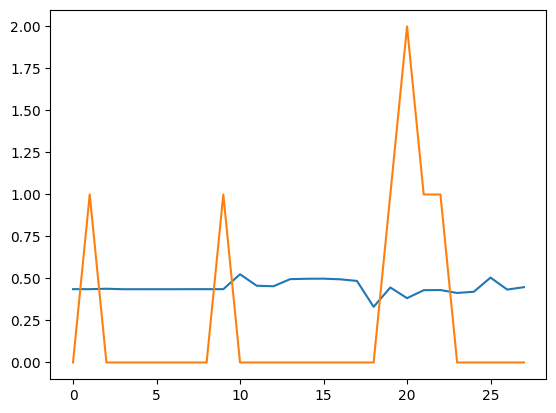

In [45]:
import matplotlib.pyplot as plt
plt.plot(range(28), y_pred)
plt.plot(range(28), Y_eval)

In [31]:
# 单一序列LSTM模型
n_time_steps = 20
import pandas as pd
import numpy as np
TMP_X = pd.DataFrame([])

TMP_X['wkd'] = weekday[:-28]
TMP_X['mon'] = month[:-28]
TMP_X['yer'] = year[:-28]
TMP_X['en1'] = eventname1[:-28]
TMP_X['en2'] = eventname2[:-28]
TMP_X['et1'] = eventtype1[:-28]
TMP_X['et2'] = eventtype2[:-28]
TMP_X['CA'] = snap_CA[:-28]
TMP_X['TX'] = snap_TX[:-28]
TMP_X['WI'] = snap_WI[:-28]


dataX = []
dataY = []
y = sales.iloc[1,6:-28]
TMP_X['pri'] = sell_price[1,:-28]
for i in range(n_time_steps, len(y)):
    dataX.append(TMP_X.iloc[i - n_time_steps:i, :])
    dataY.append(y[i])
dataX = np.array(dataX)
dataY = np.array(dataY)

In [32]:
model2 = SigLSTM()
model2.fit(dataX,dataY)
model2.predict(X_eval)

  0%|          | 0/100 [00:00<?, ?it/s]/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 100/100 [01:00<00:00,  1.65it/s]


array([[0.23449168],
       [0.24824229],
       [0.25624505],
       [0.27307728],
       [0.26107633],
       [0.29225364],
       [0.29353067],
       [0.304863  ],
       [0.30079854],
       [0.29895958],
       [0.22563334],
       [0.21980046],
       [0.17100301],
       [0.1584118 ],
       [0.12943316],
       [0.15183154],
       [0.11778583],
       [0.1737938 ],
       [0.26380435],
       [0.18464914],
       [0.19781438],
       [0.22670087],
       [0.22142634],
       [0.226801  ],
       [0.2439817 ],
       [0.27636498],
       [0.3960538 ],
       [0.07038637]], dtype=float32)

In [37]:
# 单一序列LSTM模型

n_time_steps = 20
import pandas as pd
EVAL_X = pd.DataFrame([])

EVAL_X['wkd'] = weekday[-50:]
EVAL_X['mon'] = month[-50:]
EVAL_X['yer'] = year[-50:]
EVAL_X['en1'] = eventname1[-50:]
EVAL_X['en2'] = eventname2[-50:]
EVAL_X['et1'] = eventtype1[-50:]
EVAL_X['et2'] = eventtype2[-50:]
EVAL_X['CA'] = snap_CA[-50:]
EVAL_X['TX'] = snap_TX[-50:]
EVAL_X['WI'] = snap_WI[-50:]
EVAL_X['pri'] = sell_price[1,-50:]

y = sales.iloc[1,-50:]

import numpy as np
X_eval = []
Y_eval = []
for i in range(22, len(y)):
    X_eval.append(TMP_X.iloc[i - n_time_steps:i, :])
    Y_eval.append(y[i])
X_eval = np.array(X_eval)
Y_eval = np.array(Y_eval)

In [38]:
ypred = model2.predict(X_eval)

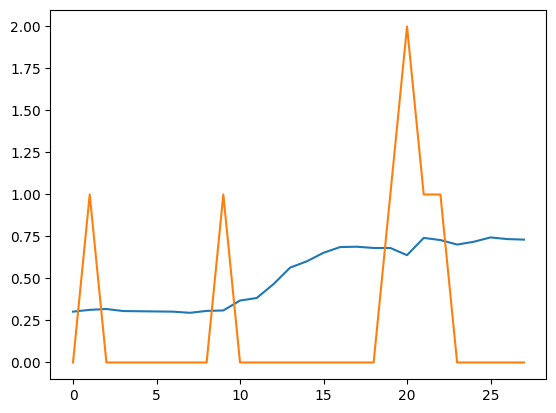

In [39]:
import matplotlib.pyplot as plt
plt.plot(range(28), y_pred)
plt.plot(range(28), Y_eval)

# 尝试合并参数

In [40]:
import torch

# 假设有两个LSTM模型，保存在model_list中
model_list = [model, model2]

# 初始化参数总和
total_params = None

# 遍历每个LSTM模型的参数，并将它们相加
for model in model_list:
    if total_params is None:
        # 如果是第一个模型，则将其参数直接赋值给参数总和
        total_params = model.state_dict()
    else:
        # 如果不是第一个模型，则将其参数与参数总和相加
        for name, param in model.state_dict().items():
            total_params[name] += param

# 将参数总和除以模型数量来求出平均值
for name in total_params:
    total_params[name] /= len(model_list)

# 将平均参数应用到每个模型中
for model in model_list:
    model.load_state_dict(total_params)

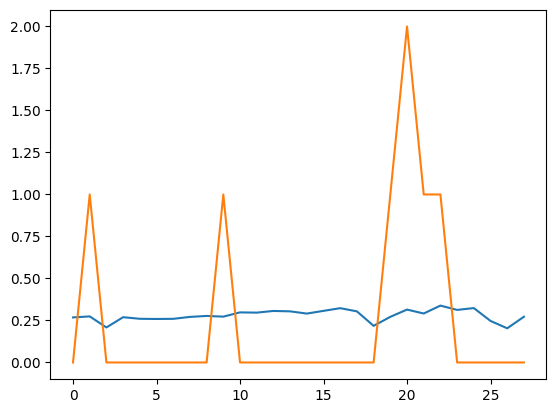

In [41]:
y_pred = model2.predict(X_eval)
import matplotlib.pyplot as plt
plt.plot(range(28), y_pred)
plt.plot(range(28), Y_eval)